### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sys import getsizeof
from time import time
from PIL import Image
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset

### Params

In [2]:
CUDA = True
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"
print(torch.cuda.is_available())
print(device)

True
cuda


In [3]:
batch_size = 10
resized = 512
num_classes = 42
lr = 0.001
epochs = 25
top_n_results = 10

### Data loading

In [4]:
# Subclassing image folder to overrride getitem to include path
class ImageFolderwPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path

In [5]:
# transformations used: resize to 512x512, normalised to torchvision values: https://pytorch.org/vision/0.12/models.html 
mods = transforms.Compose([transforms.Resize((resized,resized)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                          ])

# dataset-full; dataset-100 for 100 imgs per class; dataset-500 for 500 imgs per class
dataset = ImageFolderwPaths('dataset-500/train', mods)
train, val = random_split(dataset, [np.floor(0.8*len(dataset)).astype(np.int32), np.ceil(0.2*len(dataset)).astype(np.int32)])
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val, shuffle=False, batch_size=batch_size)

### Pre-trained CNN model

In [6]:
model = models.resnet50(pretrained=True)
# print(model)

# extract no. of features req. bef. final classifier layer, then remove the layer
final_num_feats = model.fc.in_features
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# not intending to fine-tune pre-trained model weights
for param in model.parameters():
    param.require_grad = False

model.to(device)
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Replacement Classifier layer

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(final_num_feats, num_classes)
    def forward(self, x):
        return self.fc(x)

In [8]:
classifier = Classifier().to(device)
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(classifier.parameters(), lr=lr)

### Training the Classifier

In [ ]:
loss_list = []
val_loss_list = []
start = time()

for epoch in range(epochs):
    epoch_start = time()
    
    classifier.train()
    for img, label, _ in train_loader:
        img = img.to(device)
        label = label.to(device)
        features = torch.flatten(model(img), 1)  # flatten to (batch_size, num_features)
        pred = classifier(features)
        optim.zero_grad()
        loss = loss_func(pred, label)
        loss.backward()
        optim.step()
    loss_list.append(loss.item())
    
    classifier.eval()
    with torch.no_grad():
        for img, label, _ in val_loader:
            img = img.to(device)
            label = label.to(device)
            features = torch.flatten(model(img), 1)
            pred = classifier(features)
            val_loss = loss_func(pred, label)
    val_loss_list.append(val_loss.item())
    
    print (f'Epoch: {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}, Time taken: {(time()-epoch_start)/60} mins')

print(f'Total training time for {epochs} epochs: {(time()-start)/60} mins')
torch.save(classifier, 'classifier-rn50-500i-30e.pth')

Epoch: 0, Train Loss: 2.1575448513031006, Val Loss: 0.8812288045883179, Time taken: 18.095696504910787 mins
Epoch: 1, Train Loss: 1.8677467107772827, Val Loss: 0.686820387840271, Time taken: 18.524476170539856 mins
Epoch: 2, Train Loss: 1.4870874881744385, Val Loss: 0.7518221139907837, Time taken: 16.62341465950012 mins
Epoch: 3, Train Loss: 1.088289499282837, Val Loss: 0.6786626577377319, Time taken: 17.611817304293314 mins
Epoch: 4, Train Loss: 2.0473830699920654, Val Loss: 0.5801243782043457, Time taken: 16.369593918323517 mins
Epoch: 5, Train Loss: 0.7954508662223816, Val Loss: 0.8657819628715515, Time taken: 16.37085802555084 mins
Epoch: 6, Train Loss: 0.6614475846290588, Val Loss: 0.7876172661781311, Time taken: 16.34595320224762 mins
Epoch: 7, Train Loss: 0.16611804068088531, Val Loss: 0.6548622250556946, Time taken: 16.326339030265807 mins


### Generating encodes for each category

In [8]:
dataset = ImageFolderwPaths('dataset-full/train', mods)   # training classifier on smaller dataset, but encode full dataset
category_book = {}  # {class: [(feature_vec, path), ...], ...}

start_time = time()
with torch.no_grad():
    for img, label, path in dataset:
        img = img.reshape(1, *img.shape).to(device)  # reshape to have batch_size of 1
#         print(img.shape)
        if label in category_book.keys():
            category_book[label].append((model(img).detach().squeeze().to('cpu'), path))  # squeeze to keep to a 1d feature vector
        else:
            category_book[label] = [(model(img).detach().squeeze().to('cpu'), path)]
            
print(f'Time taken to build index: {(time()-start_time)/3600} hrs')
# print(f'Size of index: {getsizeof(category_book)/1000} kilobytes')

print('\nWriting index to disk...')
with open('cat_book.pickle','wb') as f:
    pickle.dump(category_book, f)
print('Done.')

Time taken to build index: 1.1976809938086403 hrs
Size of index: 1.176 kilobytes

Writing index to disk...
Done.


### Querying

In [8]:
# if loading from disk

classifier = torch.load('classifier-100.pth')
classifier.eval()

with open('cat_book.pickle', 'rb') as f:
    category_book = pickle.load(f)

Predicted class is : 33


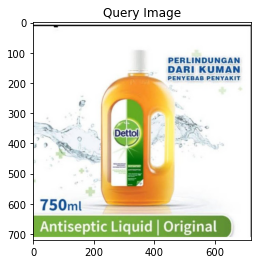

In [15]:
# Querying single image
query_file = 'dettol.jpg'
query_img = Image.open(query_file)
plt.imshow(plt.imread(query_file))
plt.title('Query Image')
query_tensor = mods(query_img)
query_tensor = query_tensor.reshape(1, *query_tensor.shape).to(device)

with torch.no_grad():
    query_feats = torch.flatten(model(query_tensor), 1)
    query_cat = classifier(query_feats)
    sm = nn.Softmax(dim=1)
    query_conf = sm(query_cat)

# print(query_conf)
pred_class = torch.argmax(query_conf).item()
print(f'Predicted class is : {pred_class}')

In [16]:
# Comparing and ranking within this predicted class 

results = [(0, '') for i in range(top_n_results)]  # keep ranking of (similarity score, path)
cat = category_book[pred_class]
cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
for img, path in cat:
    img = img.to(device)
    cos_sim_score = cos_sim(query_feats,img)
    
    # 'bubble up' found img has higher similarity score than prev lowest bound, then sort
    if cos_sim_score > results[-1][0]:
        results[-1] = (cos_sim_score, path)
        
    results = sorted(results, reverse=True)
# print(results)

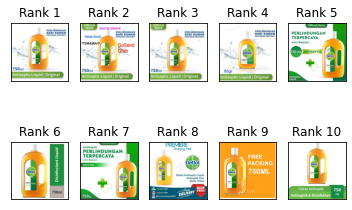

In [17]:
# Displaying results
if top_n_results%2 == 0:
    rows = 2
    cols = top_n_results//2
elif top_n_results%3 == 0:
    rows = 3
    cols = top_n_results//3
else:
    rows = 1
    cols = top_n_results

fig, chungus = plt.subplots(rows, cols)
axes = [ax for axes in chungus for ax in axes]
for i in range(len(results)):
    axes[i].imshow(plt.imread(results[i][1]))
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Rank {i+1}')

### All together as one cell

Predicted class is : 12
Time taken to retrieve: 3.9085490703582764 seconds


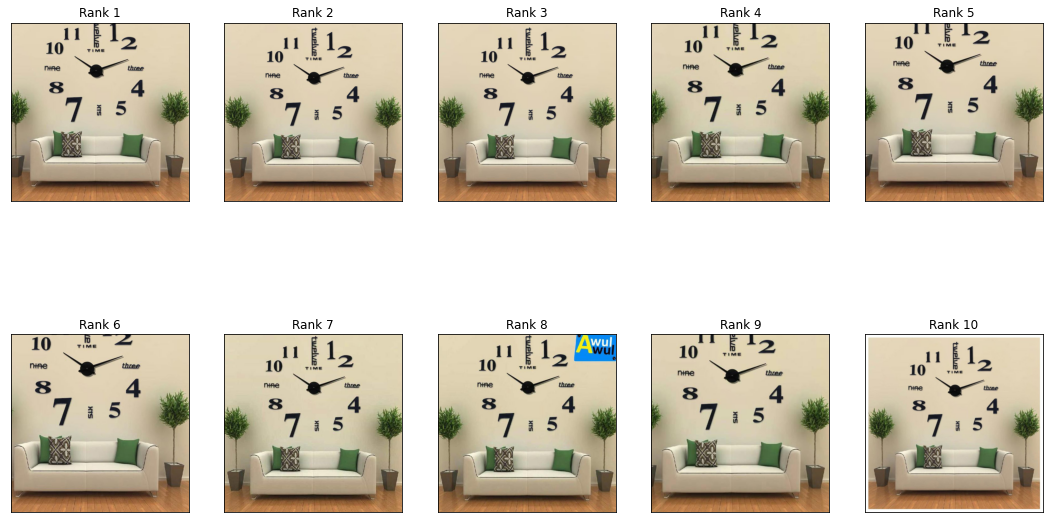

In [22]:
classifier = torch.load('classifier-100.pth')
classifier.eval()

with open('cat_book.pickle', 'rb') as f:
    category_book = pickle.load(f)
    

start_time = time()
query_file = 'sofa.jpg'
query_img = Image.open(query_file)
query_tensor = mods(query_img)
query_tensor = query_tensor.reshape(1, *query_tensor.shape).to(device)

with torch.no_grad():
    query_feats = torch.flatten(model(query_tensor), 1)
    query_cat = classifier(query_feats)
    sm = nn.Softmax(dim=1)
    query_conf = sm(query_cat)

# print(query_conf)
pred_class = torch.argmax(query_conf).item()
print(f'Predicted class is : {pred_class}')

results = [(0, '') for i in range(top_n_results)]  # keep ranking of (similarity score, path)
cat = category_book[pred_class]
cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
for img, path in cat:
    img = img.to(device)
    cos_sim_score = cos_sim(query_feats,img)
    
    # 'bubble up' found img has higher similarity score than prev lowest bound, then sort
    if cos_sim_score > results[-1][0]:
        results[-1] = (cos_sim_score, path)
        
    results = sorted(results, reverse=True)
    
# Displaying results
if top_n_results%2 == 0:
    rows = 2
    cols = top_n_results//2
elif top_n_results%3 == 0:
    rows = 3
    cols = top_n_results//3
else:
    rows = 1
    cols = top_n_results

fig, chungus = plt.subplots(rows, cols)
fig.set_size_inches(18.5, 10.5)
axes = [ax for axes in chungus for ax in axes]
for i in range(len(results)):
    axes[i].imshow(plt.imread(results[i][1]))
    axes[i].set_yticks([])
    axes[i].set_xticks([])
    axes[i].set_title(f'Rank {i+1}')

print(f'Time taken to retrieve: {time()-start_time} seconds')